In [1]:
"""
This notebook shows some basic and popular debluring and denoising algorithms.  
1. Wiener Deconvolution
2. Variational Approach
    (a). Deconvolution by L2 Regularization (Tikhonov model)
    (b). Deconvolution by Total Variation(TV/L1) Regularization (ROF model)

Author: Yingying Gu
Date: 2016-10-26
"""

print __doc__



This notebook shows some basic and popular debluring and denoising algorithms.  
1. Wiener Deconvolution
2. Variational Approach
    (a). Deconvolution by L2 Regularization (Tikhonov model)
    (b). Deconvolution by Total Variation(TV/L1) Regularization (ROF model)

Author: Yingying Gu
Date: 2016-10-26



(<matplotlib.image.AxesImage at 0x7fdceee91790>,
 <matplotlib.text.Text at 0x7fdceeeb5d50>)

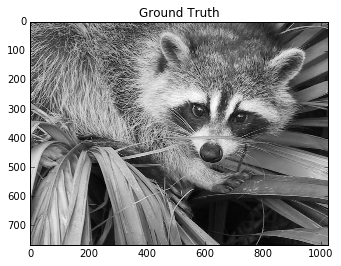

In [2]:
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
ref = misc.face(gray=True)
plt.imshow(ref, cmap=plt.cm.gray), plt.title('Ground Truth')

(<matplotlib.image.AxesImage at 0x7fdcdebc9a90>,
 <matplotlib.text.Text at 0x7fdcdec158d0>)

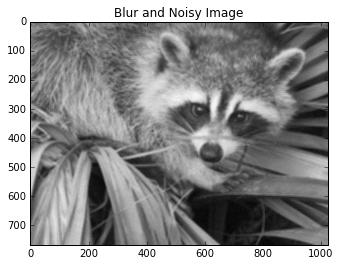

In [3]:
# Blur the ref image and add Gaussian noise to the image
from scipy import signal
import numpy as np
ref = np.array(ref)
M,N=ref.shape
K=np.ones([9,9]) # average kernel
K=K/K.sum()
B = signal.convolve2d(ref, K, mode='same', boundary='symm') # blurred face
sigma=3
Bn = B+np.random.randn(M,N)*sigma # add Gaussian noise
plt.imshow(Bn, cmap=plt.cm.gray), plt.title('Blur and Noisy Image')

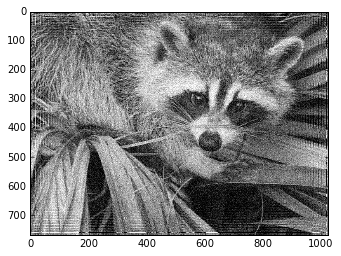

In [4]:
# Wiener Deconvolution
# Definition and Derivation: https://en.wikipedia.org/wiki/Wiener_deconvolution
from scipy import fftpack
H=np.fft.fft2(K, s=[M,N]) 
F=np.fft.fft2(Bn)
NSR=1.0/1000.0  # noise-to-signal ratio

G=np.conjugate(H)/((abs(H))**2+NSR)
wienerDecon=(np.fft.ifft2(F*G)).real
plt.imshow(wienerDecon,cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)


In [5]:
# calculate the gradient of 2D image
def grad(u):
    gradfx=np.zeros([M,N])
    gradfx[:M-1,:]=u[1:,:]
    gradfx[M-1,:]=u[M-1,:]
    gradfx=gradfx-u

    gradfy=np.zeros([M,N])
    gradfy[:,:N-1]=u[:,1:]
    gradfy[:,N-1]=u[:,N-1]
    gradfy=gradfy-u
    return gradfx, gradfy

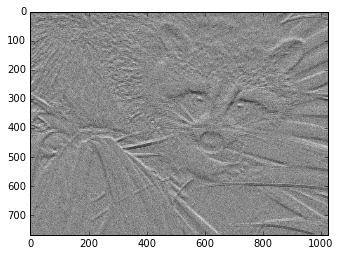

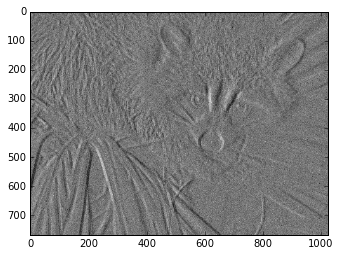

In [6]:
gradfx, gradfy=grad(Bn)
plt.imshow(gradfx,cmap=plt.cm.gray)
plt.figure()
plt.imshow(gradfy,cmap=plt.cm.gray)

In [7]:
# Deconvolution by L2 Regularization (Tikhonov model)
# TODO